In [12]:
import torch
import numpy as np

In [13]:
from networks.faceid.sphereface import sphere20a
from networks.denoise.pydl import ResDNet
from networks.denoise.pydl import UDNet
from networks.denoise.pydl import UDNetPA

In [14]:
#faceid = networks.sphereface.sphere20a()
faceid = sphere20a()

In [15]:
import os

gpu_id = 0
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]=str(gpu_id)

In [16]:
denoiser = ResDNet(kernel_size = (5, 5),
                input_channels = 3,
                output_features = 32,
                rpa_depth = 7,
                shortcut=(False,True))
denoiser_ckpt = torch.load("/home/safin/cpkt/1st_udnetpa/weigths_31")
denoiser.load_state_dict(denoiser_ckpt)
denoiser.cuda()

ResDNet(depth = 7, convWeightSharing = True, shortcut = (False, True, True, True, True, True, True))

In [17]:
from datasets.noised import NoisedDataset

In [18]:
from torchvision import datasets, transforms

import random
class GaussianNoise(object):
    def __init__(self, std, mean=0, threshold = 0.5):
        self.std = std
        self.mean = mean
        self.threshold = threshold

    def __call__(self, img):
        if random.random() > self.threshold:
            return img
        
        if isinstance(self.std, list):
            std = np.random.choice(self.std)
        else:
            std = self.std
        return torch.clamp(img + torch.randn(*img.shape)*std + self.mean, 0, 1)
#         return img + torch.randn(*img.shape)*std + self.mean
#         return img + np.random.randn(*img.shape)*std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)
    

high_noise_std_arr = (np.arange(30, 55, 4)/255).tolist()

train_data_dir = "/home/safin/datasets/CASIA-WebFace-sphereface/"
transform = transforms.Compose([
                         transforms.RandomCrop((112,96)),
                         transforms.RandomHorizontalFlip(),
                         transforms.ToTensor()
                     ])
noised_dataset = NoisedDataset(train_data_dir, transform=transform, noise_transform=GaussianNoise(std=high_noise_std_arr, threshold=0.7))

In [19]:
batch_size = 10
dataloader_test = torch.utils.data.dataloader.DataLoader(noised_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=16)

import sys
sys.path.append("/home/safin/")
from pydl import utils as pydlutil

for batch_idx, sample in enumerate(dataloader_test):
    noised, groundtruth = sample
    noised, groundtruth = noised.cuda(), groundtruth.cuda()
    sigma = pydlutil.wmad_estimator(noised)
    sigma = sigma.cuda()
    prediction = denoiser(noised, sigma)
    break

In [20]:
noised = noised.data.cpu().permute(0, 2, 3, 1).numpy()
prediction = prediction.data.cpu().permute(0, 2, 3, 1).numpy()
groundtruth = groundtruth.data.cpu().permute(0, 2, 3, 1).numpy()

denoised = prediction.astype(np.uint8)
noised = noised.clip(0,255).astype(np.uint8)
groundtruth = groundtruth.astype(np.uint8)

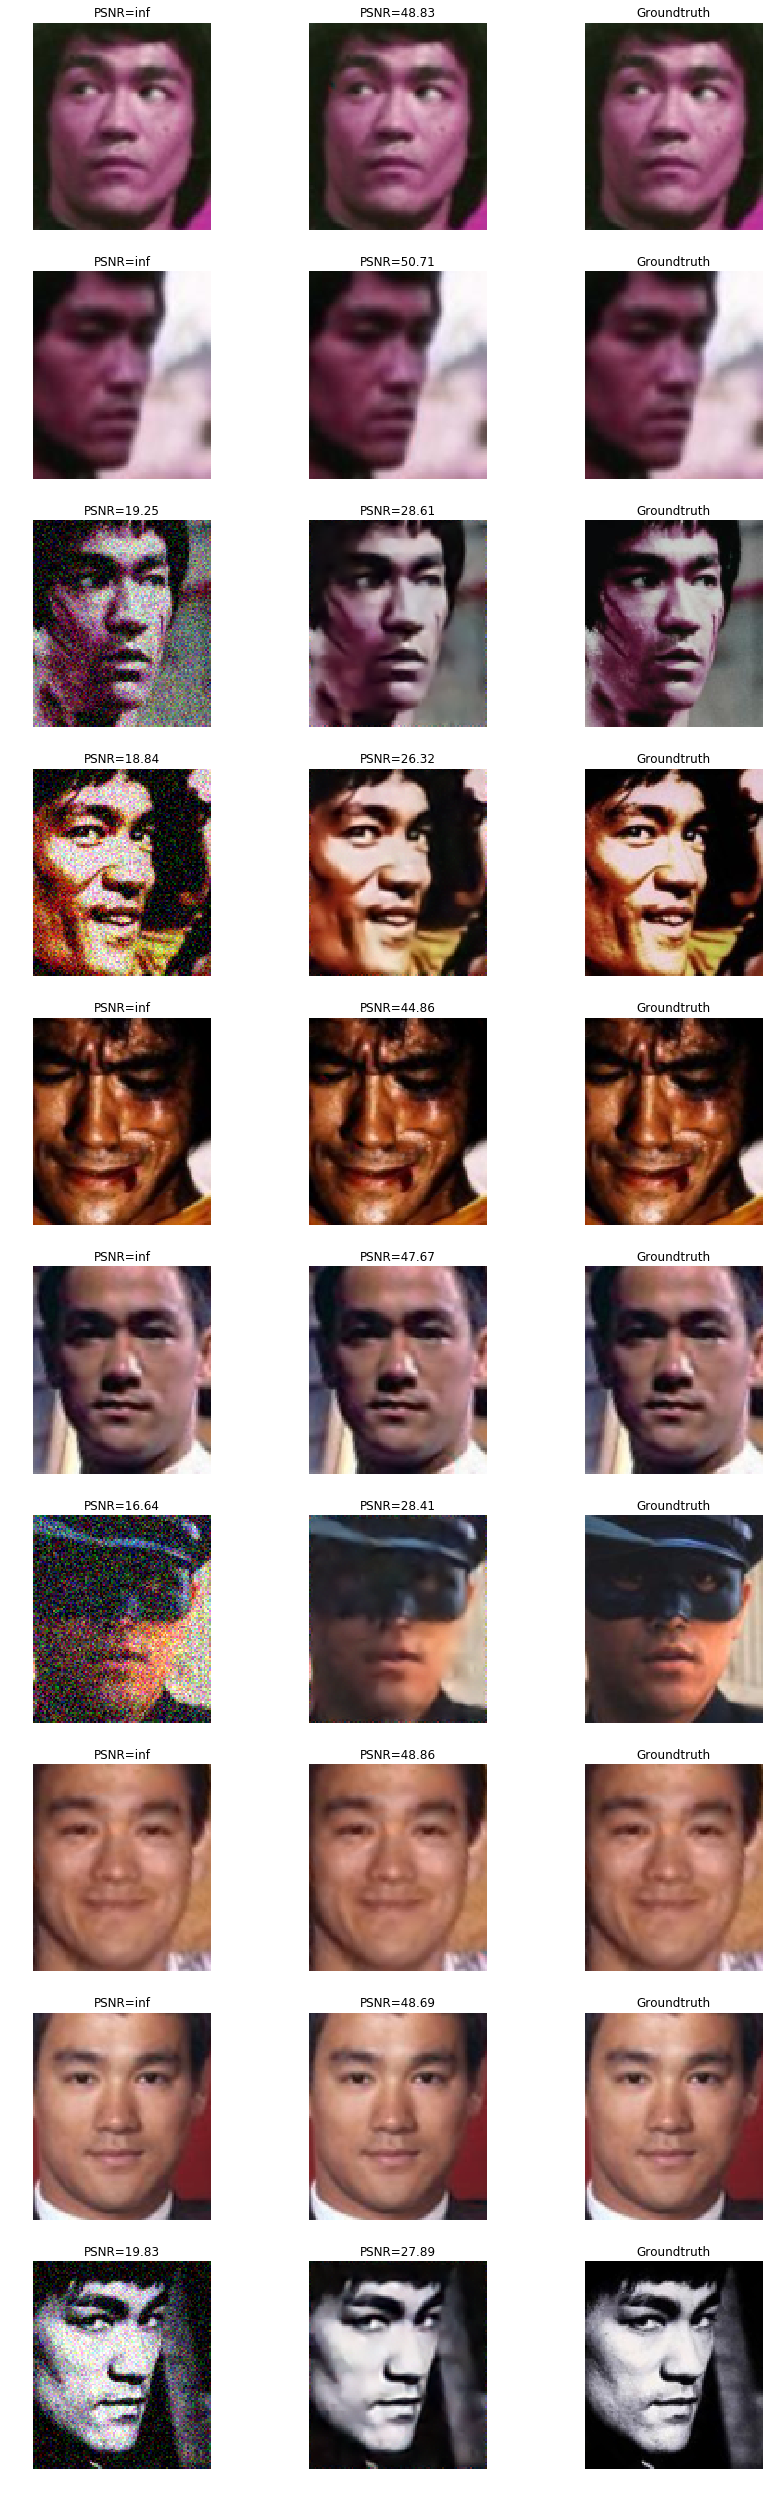

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
def psnr(img1, img2, PIXEL_MAX):
    mse = np.mean( (img1.astype(np.float32) - img2.astype(np.float32)) ** 2 )
    if mse == 0:
        return np.inf
    return 20 * np.log10(PIXEL_MAX / np.sqrt(mse))

w = 14
h = 45

columns = 3
rows = batch_size
fig=plt.figure(figsize=(w, h))

for i in range(rows):
    fig.add_subplot(rows, columns, 1+i*columns)
    plt.imshow(noised[i])
    plt.axis('off')
    noised_psnr = psnr(noised[i], groundtruth[i], PIXEL_MAX=255)
    plt.title("PSNR=%.2f" % noised_psnr)
    
    fig.add_subplot(rows, columns, 1+i*columns+1)
    plt.imshow(denoised[i])
    plt.axis('off')
    denoised_psnr = psnr(denoised[i], groundtruth[i], PIXEL_MAX=255)
    plt.title("PSNR=%.2f" % denoised_psnr)
       
    fig.add_subplot(rows, columns, 1+i*columns+2)
    plt.imshow(groundtruth[i])
    plt.axis('off')
    plt.title("Groundtruth")